# Momentos y la ley de Zipf

In [184]:
from collections import Counter

import re
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kurtosis, cauchy, binom
from sklearn.feature_extraction.text import CountVectorizer

import requests

np.random.seed(42)

## Recap de momentos

In [185]:
dataset = pd.read_csv("cashback_dataset.csv")
dataset

,id,age,gender,income,education,region,purchase_frequency,purchase_amount,product_category,cuenta_con_cashback
0,1,27,Male,40682,Bachelor,East,frequent,18249,Books,yes
1,2,29,Male,15317,Masters,West,rare,4557,Clothing,no
2,3,37,Male,38849,Bachelor,West,rare,11822,Clothing,yes
3,4,30,Male,11568,HighSchool,South,frequent,4098,Food,no
4,5,31,Female,46952,College,North,occasional,19685,Clothing,no
...,...,...,...,...,...,...,...,...,...,...
99995,99996,31,Female,19691,College,West,occasional,7075,Health,no
99996,99997,36,Male,17428,HighSchool,South,rare,6873,Health,no
99997,99998,29,Male,13222,College,West,frequent,5152,Clothing,no
99998,99999,31,Female,40093,Bachelor,West,frequent,16312,Health,no


In [ ]:
# Cada columna (numérica) es una variable. Elijamos una.
X = dataset["purchase_amount"]

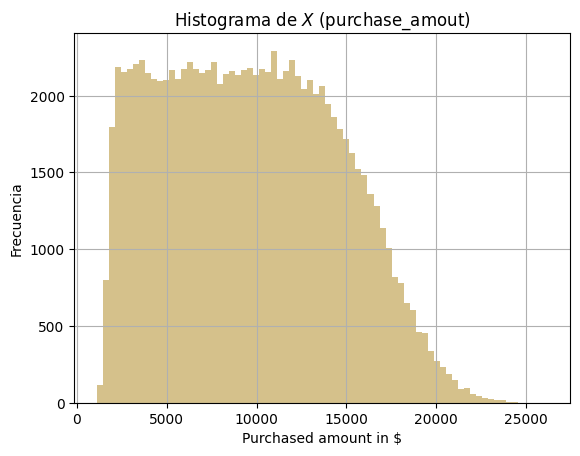

In [188]:
# ¿Cómo se distribuye X?
ax = X.hist(bins='fd', color='#D5C18B') # Freedman-Diaconis

ax.set_xlabel('Purchased amount in $')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma de $X$ (purchase_amout)')
plt.show()

### Valor esperado o media

Para una variable aleatoria (teórica):
$$
\mu = \mathbb{E}[X] = \sum_x x \, P(X = x) \quad \text{o, en caso continuo,} \quad \mu = \mathbb{E}[X] = \int_{-\infty}^{\infty} x \, f_X(x) \, dx
$$

Para un dataset (empírico):
$$
\hat{\mu} = \frac{1}{n} \sum_{i=1}^n X_i
$$

In [189]:
mean_X = X.mean()
mean_X

9634.79084

### Varianza y desviación estándar

$$
\sigma^2 = \mathrm{Var}(X) = \mathbb{E}[(X - \mathbb{E}[X])^2]
$$

$$
\text{Pandas usa el estimador insesgado: }\hat{\sigma}^2 = \frac{1}{n - 1} \sum_{i=1}^n (X_i - \hat{\mu})^2 
$$


In [190]:
var_X = X.var()
var_X

23033659.149623588

$$
\sigma_X = \sqrt{\mathrm{Var}(X)}


In [191]:
std_X = math.sqrt(var_X)
std_X

4799.339449301704

In [192]:
# Alternativamente...
X.std()

4799.339449301704

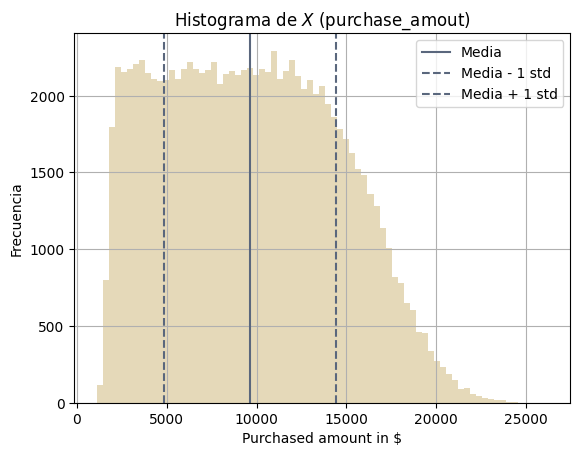

In [193]:
ax = X.hist(alpha=0.6, bins='fd', color='#D5C18B')

ax.axvline(mean_X, color='#5A677D', linestyle='-', label='Media')
ax.axvline(mean_X - std_X, color='#5A677D', linestyle='--', label='Media - 1 std')
ax.axvline(mean_X + std_X, color='#5A677D', linestyle='--', label='Media + 1 std')

ax.set_xlabel('Purchased amount in $')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma de $X$ (purchase_amout)')

ax.legend()
plt.show()

### Curtosis

La curtosis mide qué tan pesadas o extremas son las colas de una distribución en comparación con una distribución normal.

$$
\text{Curtosis}(X) = \frac{\mathbb{E}[(X - \mathbb{E}[X])^4]}{\big(\mathrm{Var}(X)\big)^2}
$$

Curtosis de la distribución Laplace simulada: 6.0384
Exceso de curtosis: 3.0384


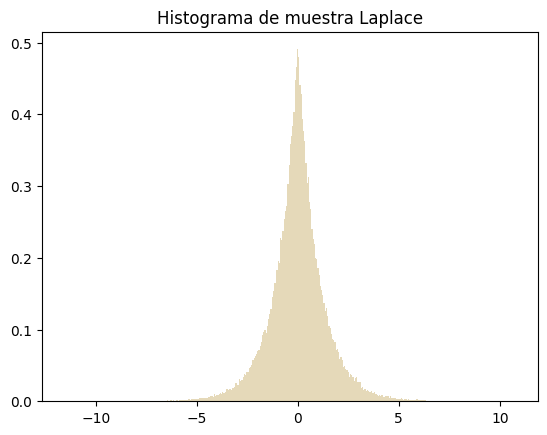

In [195]:
# Cambiemos momentánemente de distribución y simulemos una distribución de Laplace

# Parámetros de la distribución de Laplace
loc = 0.0    # media
scale = 1.0  # escala (b)

# Simulamos 100,000 experimentos Laplace
n = 100_000
data = np.random.laplace(loc, scale, n)

# Calculamos curtosis (Fisher=False para curtosis estándar, no exceso)
curt = kurtosis(data, fisher=False)
exc_curt = kurtosis(data, fisher=True)

print(f'Curtosis de la distribución Laplace simulada: {curt:.4f}')
print(f'Exceso de curtosis: {exc_curt:.4f}')

# Gráfica del histograma
plt.hist(data, bins='fd', density=True, alpha=0.6, color='#D5C18B')
plt.title('Histograma de muestra Laplace')
plt.show()


### Covarianza y correlación (de Pearson)

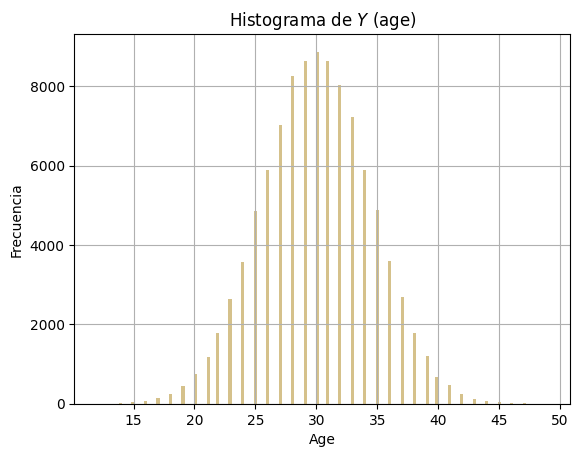

In [197]:
# Obtengamos una segunda variable de nuestro dataset
Y = dataset["age"]

ax = Y.hist(bins='fd', color='#D5C18B')
ax.set_xlabel('Age')
ax.set_ylabel('Frecuencia')
ax.set_title('Histograma de $Y$ (age)')
plt.show()

$$
\mathrm{Cov}(X, Y) = \mathbb{E}[(X - \mathbb{E}[X])(Y - \mathbb{E}[Y])]
$$


In [198]:
cov_XY = X.cov(Y)
cov_XY

-44.911547253872556

$$
\rho_{X,Y} = \frac{\mathrm{Cov}(X,Y)}{\sigma_X \sigma_Y}
$$


In [199]:
std_Y = Y.std()

corr = cov_XY / (std_X * std_Y)
corr

-0.002088558844140835

El coeficiente de correlación de Pearson ($\rho$), mide la fuerza y dirección de la relación lineal entre dos variables aleatorias.  

Su valor siempre está en el rango:  
$$
-1 \leq \rho \leq 1
$$

- $\rho = 1$: correlación lineal positiva perfecta (ambas variables aumentan juntas).  
- $\rho = -1$: correlación lineal negativa perfecta (una variable aumenta mientras la otra disminuye).  
- $\rho = 0$: no existe relación lineal (aunque puede haber dependencia no lineal).  

Valores cercanos a \(1\) o \(-1\) indican relaciones lineales fuertes, mientras que valores cercanos a 0 indican relaciones lineales débiles o nulas.


Caveat: https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#/media/File:Correlation_examples2.svg

## Varianza infinita

Las distribuciones con varianza infinita tienen colas “pesadas” que decrecen a una tasa extremadamente lenta. Intuitivamente, esto significa que la distribución tarda muchísimo tiempo en “desaparecer” (y, en teoría, nunca desaparece).

Esto aumenta las probabilidades de valores muy extremos (outliers).  

Aunque una distribución tenga varianza infinita, esto no implica que el fenómeno real que se modela también se extienda hasta el infinito. Algunos factores influyen en la decisión de adoptar un modelo con varianza infinita son:

- La función de distribución empírica del conjunto de datos parece decaer siguiendo una ley de potencias.  
- El exponente de la ley de potencias $\alpha$ es menor que 2.


### Un ejemplo: distribución de Cauchy

La función de densidad de una variable aleatoria (que se distribuye) Cauchy es:  

$$
f(x; x_0, \gamma) = \frac{1}{\pi \gamma \left[1 + \left(\frac{x - x_0}{\gamma}\right)^2\right]}
$$

donde $ x_0 $ es la ubicación y $ \gamma > 0 $ la escala.  

Al intentar calcular $ \mathbb{E}[X] $ o $ \mathrm{Var}(X) $, las integrales respectivas no convergen.


Cauchy - Varianza empírica: 4354059.6120 (muy grande o indefinida)


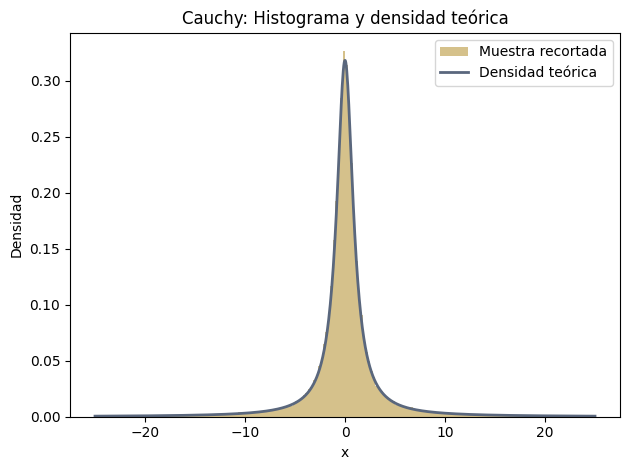

In [20]:
# Distribución de Cauchy
# Simulamos 100,000 experimentos Cauchy
n = 100_000
cauchy_data = np.random.standard_cauchy(n)

# Recortamos extremos para visualizar histograma (¿por qué?)
cauchy_data_rec = cauchy_data[(cauchy_data > -25) & (cauchy_data < 25)]

# Varianza empírica puede ser enorme o NaN (no definida)
try:
    cauchy_var = np.var(cauchy_data)
except FloatingPointError:
    cauchy_var = float('nan')

print(f'Cauchy - Varianza empírica: {cauchy_var:.4f} (muy grande o indefinida)')

# Histograma
plt.hist(cauchy_data_rec, bins=200, density=True, color='#D5C18B', label='Muestra recortada')
x = np.linspace(-25, 25, 1000)
# FMP
pdf = cauchy.pdf(x)
plt.plot(x, pdf, '-', lw=2, label='Densidad teórica', color='#5A677D')

plt.title('Cauchy: Histograma y densidad teórica')
plt.xlabel('x')
plt.ylabel('Densidad')
plt.legend()
plt.tight_layout()
plt.show()


La distribución de Cauchy sirve para modelar fenómenos naturales y físicos, por ejemplo:

- **Resonancia en física:** Describe la forma de líneas de resonancia en espectros atómicos y moleculares, donde las desviaciones grandes son frecuentes.

- **Fenómenos de dispersión:** Modela la distribución de posiciones o energías en procesos de dispersión de partículas y ondas con interacciones fuertes.

- **Procesos de mezcla y fluctuaciones:** En mezclas turbulentas o sistemas caóticos, variables asociadas pueden seguir distribuciones con colas pesadas similares a la Cauchy.

- **Errores de medición con outliers grandes:** En análisis de datos con errores atípicos muy grandes, la distribución de Cauchy puede describir mejor esos errores que la normal.


## Leyes de potencias (Zipf) y gráficas log-log

In [200]:
# Retomemos el libro de Drácula
response = requests.get("https://www.gutenberg.org/cache/epub/345/pg345.txt")
libro = response.text

In [31]:
palabras = re.findall(r'\b\w+\b', libro.lower())
n = len(palabras)

print(f'Total de palabras en Drácula: {n}')

Total de palabras en Drácula: 167088


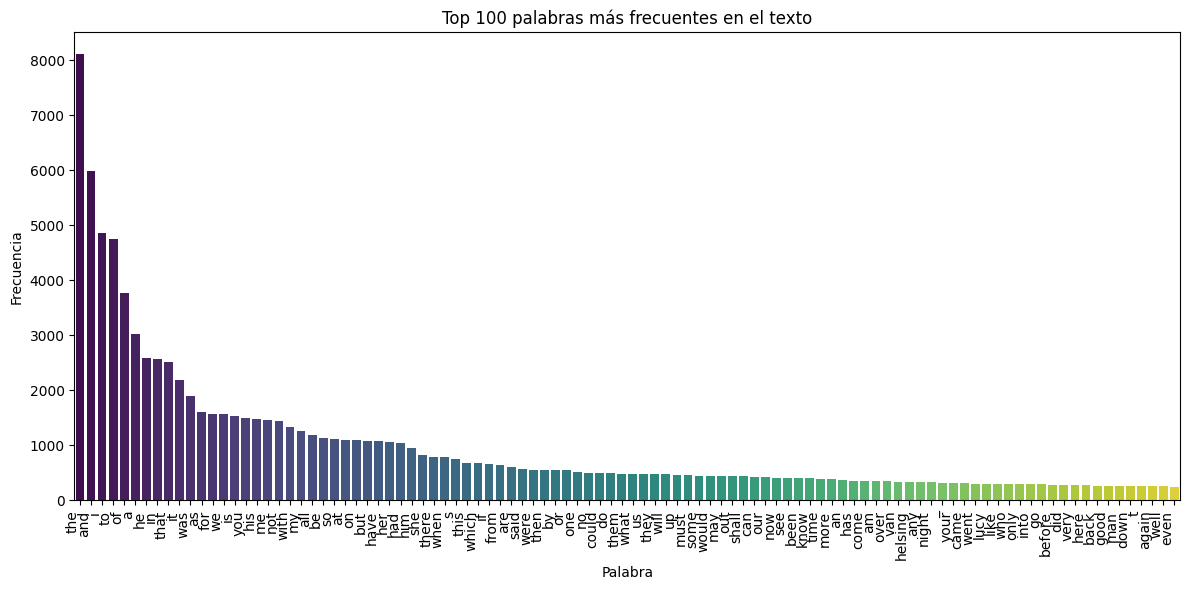

In [35]:
# Contar frecuencias
conteo = Counter(palabras)

# Obtener las k palabras más comunes
k = 100
palabras_mas_comunes = conteo.most_common(k)

vocabulario, frecuencias = zip(*palabras_mas_comunes) # Desempaque y luego zip
# vocabulario = ('hola', 'mundo', 'python')
# frecuencias = (5, 3, 7)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(vocabulario), y=list(frecuencias), palette='viridis', hue=list(vocabulario), legend=False)
plt.xticks(rotation=90, ha='right')
plt.title(f"Top {k} palabras más frecuentes en el texto")
plt.xlabel("Palabra")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

### Ley de Zipf

Para cada palabra, considera su ranking $r$:
 1. `"the"`: $r = 1$ (más frecuente)
 2. `"and"`: $r = 2$ (segunda más frecuente)
 3. `"i"`: $r = 3$ (tercera más frecuente)
y así sucesivamente.

Decimos que un dataset sigue la **ley de Zipf** si:

$$f(r) \propto \frac{1}{r^\alpha}$$

donde $f$ nos da la frecuencia o conteo de la palabra con rango $r$ (por ejemplo, $f(1) = 8101$). Dicho de otro modo, 

$$f(r) = C\frac{1}{r^\alpha}$$

para alguna constante $C$.

In [36]:
# Obtención del arreglo de frecuencias (f)
freqs = np.array(sorted(conteo.values(), reverse=True)) # Ordenamos de mayor a menor

In [37]:
# Obtención del arreglo de ranking (r)
ranks = np.arange(1, len(freqs) + 1)

Note que si toma logaritmos de ambos lados, llegamos a la fórmula:

$$\log f(r) = - \alpha \log r + \log C  $$

la cual es la ecuación de una recta en su forma $ y = mx + b $.

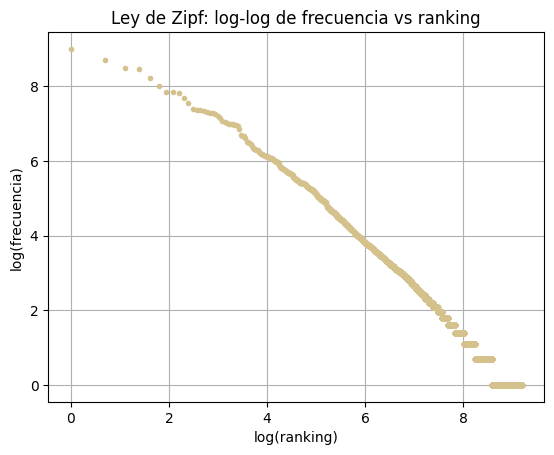

In [41]:
# Así, si al graficar log[f(r)] vs log[r] obtenemos una recta, entonces podemos decir que nuestro dataset sigue una ley de Zipf.
log_freqs = np.log(freqs)
log_ranks = np.log(ranks)

# Log-log plot
plt.plot(log_ranks, log_freqs, marker='.', linestyle='none', color="#D5C18B")
plt.xlabel('log(ranking)')
plt.ylabel('log(frecuencia)')
plt.title('Ley de Zipf: log-log de frecuencia vs ranking')
plt.grid(True)
plt.show()

Para que la varianza sea infinita, se requiere que  
$$
\alpha < 2
$$

In [53]:
coef = np.polyfit(log_ranks, log_freqs, 1) # Regresión lineal

pendiente = coef[0]
intercepto = coef[1]

alpha = -pendiente
print(f"Estimación de alpha: {alpha:.4f}")


Estimación de alpha: 1.2852


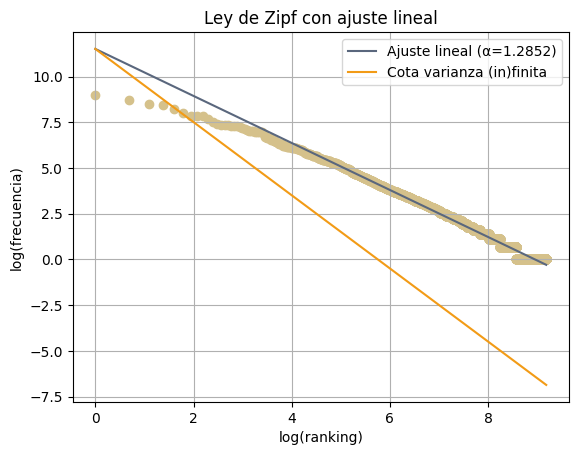

In [54]:
# Gráfica del ajuste
log_freqs_fit = pendiente * log_ranks + intercepto
plt.scatter(log_ranks, log_freqs, color='#D5C18B')
plt.plot(log_ranks, log_freqs_fit, color='#5A677D', label=f'Ajuste lineal (α={alpha:.4f})')
plt.plot(log_ranks, -2 * log_ranks + intercepto, color='#F29B16', label='Cota varianza (in)finita')
plt.xlabel('log(ranking)')
plt.ylabel('log(frecuencia)')
plt.title('Ley de Zipf con ajuste lineal')
plt.legend()
plt.grid(True)
plt.show()

## Obteniendo ¿binomiales?

Recordar que la suma de variables aleatorias independientes e idénticamente distribuidas (iid) de Bernoulli con parámetro $ p $ sigue una distribución binomial:  
$$
S_n = \sum_{i=1}^n X_i \sim \mathrm{Binomial}(n, p)
$$


In [104]:
# Separemos a nuestro libro en capítulos
inicio = libro.find("CHAPTER I")
final = libro.find("End of the Project Gutenberg EBook")
libro_cuerpo = libro[inicio:final].strip()

# El patrón busca "CHAPTER" + número romano, y corta antes del siguiente
capitulos_raw = re.split(r'(CHAPTER [IVXLCDM]+)', libro_cuerpo)

In [201]:
# Hacemos que cada capítulo sea un solo string
capitulos = []
for i in range(1, len(capitulos_raw), 2):  # índice 1: título, índice 2: contenido
    titulo = capitulos_raw[i].strip()
    contenido = capitulos_raw[i+1].strip() if i+1 < len(capitulos_raw) else ""

    # Limpieza de string
    texto = f"{titulo}\n{contenido}".replace("\n", " ").replace("\r", "").replace("«", "").replace("»", "").replace("-", "").replace("_","").replace(".", " ")
    texto_sin_numeros = re.sub(r'\d+', '', texto)
    capitulos.append(texto_sin_numeros)

capitulos = capitulos[27:] # Nos deshacemos del índice
print(f"Se cuenta con {len(capitulos)} capítulos.")

Se cuenta con 27 capítulos.


In [161]:
# El capítulo I, por ejemplo
capitulos[0][:250]

'CHAPTER I JONATHAN HARKER’S JOURNAL  (Kept in shorthand )    May  Bistritz Left Munich at : P  M , on st May, arriving at Vienna early next morning; should have arrived at :, but train was an hour late  BudaPesth seems a wonderful place, from the gli'

In [162]:
# Construimos el vectorizador
vectorizer = CountVectorizer(binary=True)  # binary=True para 1/0 en vez de conteos
X = vectorizer.fit_transform(capitulos)

# Creamos el dataframe
bllis = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
bllis

,aback,abaft,abandon,abandoned,abasement,abated,abating,abbey,abed,abelderin,...,youyes,yus,zeal,zealous,zoo,zoölogical,zoöphagous,zoöphagy,æt,ætat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,1,0,1,0
6,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


Podemos ver a cada palabra (columna) como una variable Bernoulli, y a cada capítulo como un experimento.

In [164]:
# El parámetro p para cada palabra, de manera empírica
p_s = bllis.sum(axis=0) / 27
p_s

aback         0.037037
abaft         0.037037
abandon       0.037037
abandoned     0.074074
abasement     0.037037
                ...   
zoölogical    0.074074
zoöphagous    0.185185
zoöphagy      0.037037
æt            0.037037
ætat          0.037037
Length: 10353, dtype: float64

Ahora bien, ¿`total_palabras_distintas` se distribuye binomial? A fin de cuentas, es una suma de Bernoullis.

In [166]:
bllis['total_palabras_distintas'] = bllis.sum(axis=1) # total_palabras_distintas
bllis.head(10)

,aback,abaft,abandon,abandoned,abasement,abated,abating,abbey,abed,abelderin,...,yus,zeal,zealous,zoo,zoölogical,zoöphagous,zoöphagy,æt,ætat,total_palabras_distintas
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2926
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2648
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2826
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2712
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1718
5,0,1,0,0,0,0,0,1,0,1,...,0,0,0,0,0,1,0,1,0,2842
6,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,2936
7,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,2880
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2470
9,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,2496


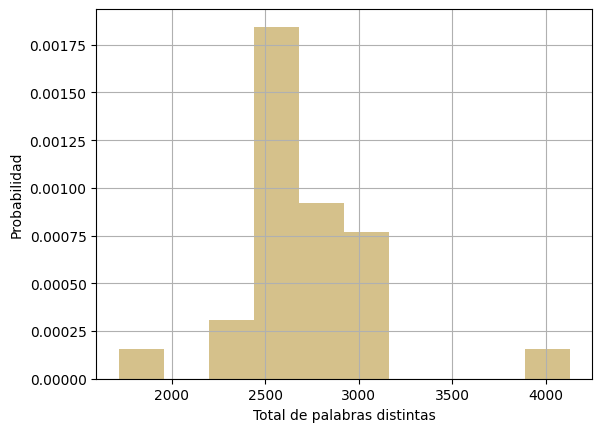

In [167]:
ax = bllis['total_palabras_distintas'].hist(bins='fd', density=True, color="#D5C18B")
ax.set_xlabel('Total de palabras distintas')
ax.set_ylabel('Probabilidad')
plt.show()

In [182]:
# Parámetros para la binomial
n = 10354
p = np.mean(p_s)

print(f"Utilizaremos una binomial con parámetros n={n} y p={p:.3f}")

Utilizaremos una binomial con parámetros n=10354 y p=0.131


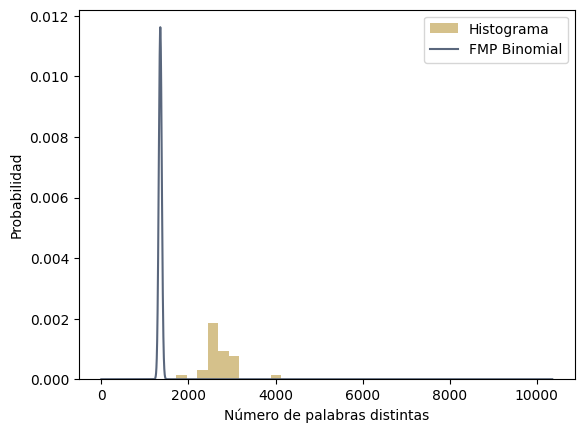

In [183]:
# Valores observados
_bin_ = bllis['total_palabras_distintas']

x = np.arange(n+1)
pmf_binomial = binom.pmf(x, n, p)

# Gráfica de los datos (histograma)
plt.hist(_bin_, bins='fd', density=True, color="#D5C18B", label='Histograma')

# Gráfica de la binomial (teórica)
plt.plot(x, pmf_binomial, color='#5A677D', label='FMP Binomial')

plt.xlabel('Número de palabras distintas')
plt.ylabel('Probabilidad')
plt.legend()
plt.show()


¿Cuáles hipótesis no se cumplieron?